In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 02:  Descriptives
 * Name and franchise code (non independent observations)
 * Bank
 * Correlations

I do not do extensive data exploration but instead use others' insights from various
Kaggle projects, especially:
* https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer

I am also not going to use all the features I could.  I want to focus on NAICS, and so I don't do a lot with bank, franchise, or geography.

*This script takes about 1 minute on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import re, importlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 
sg_plot.plot_defaults()

## Import Data

In [5]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [6]:
sba_loans.shape

(688081, 49)

In [7]:
sba_loans.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,menc_NAICS_sector,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn
index,,,,,,,,,,,,,,,,,,,,,
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,...,0.225793,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,...,0.217493,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,...,0.100900,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,1997-02-28,1997,...,0.155421,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,1997-02-28,1997,...,0.202440,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy().reset_index(drop=True)

In [9]:
train_df.shape

(425594, 49)

##### NAICS descriptions

In [10]:
naics_desc = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_naics07_descriptions.parquet')) \
    .drop_duplicates('NAICS07')

## Name and Franchise
These features are important to me because they may indicate non-independent observations.  There may be multiple loans for the same business.  Or, we may have multiple branches of a franchise who are not independent

For this project I am not likely to do anything to account for potential leakage or distortions due to non-independence.  This may be something a GNN will be helpful for and I may explore that in the future

I am not even going to do my train/test split by name or franchise, which would normally be the minimum I'd do with non-independent observations

##### Name - are there repeat loans?

In [11]:
print(sba_loans.shape)
print(sba_loans.drop_duplicates(['Name']).shape)
print(sba_loans.drop_duplicates(['Name', 'Zip', 'City', 'State']).shape)

(688081, 49)
(604551, 49)
(641628, 49)


In [12]:
# It looks like most repeat names are multi-locations (same name different address(  
# There are a few same name/location cases, probably the same business getting multiple loans.

In [13]:
sba_loans['Name'].value_counts().head(5)

Name
SUBWAY                 913
QUIZNO'S SUBS          412
COLD STONE CREAMERY    348
THE UPS STORE          321
QUIZNO'S               310
Name: count, dtype: int64

In [14]:
# It appears that large franchises are getting many loans

In [15]:
sba_loans.groupby(['Name', 'Zip', 'City', 'State'])['franchise_flag'] \
    .agg(['count', 'mean']) \
    .sort_values('count', ascending=False) \
    .head()

,,,,count,mean
Name,Zip,City,State,,
WEST TEXAS LEE CO INC,79329,IDALOU,TX,39,0.0
"ERIE PETROLEUM, INC.",16512,ERIE,PA,25,0.0
"Meathead Movers, Inc.",93401,SAN LUIS OBISPO,CA,23,0.0
"COLCHESTER HOLDINGS, INC.",13755,DOWNSVILLE,NY,18,0.0
UNITED STEEL FABRICATORS,45365,SIDNEY,OH,15,0.0


In [16]:
# There are some non-franchises getting tons of loans also

## Banks
I won't do anything with bank for this project, but it could also be an interesting GNN application in the future

##### Bank - loans per bank and histogram

In [17]:
sba_loans['Bank'].value_counts(dropna=False).head()

Bank
BANK OF AMERICA NATL ASSOC        74591
WELLS FARGO BANK NATL ASSOC       42259
JPMORGAN CHASE BANK NATL ASSOC    41012
CITIZENS BANK NATL ASSOC          32227
U.S. BANK NATIONAL ASSOCIATION    26866
Name: count, dtype: int64

In [18]:
sba_loans['Bank'].value_counts(dropna=False).shape

(5133,)

In [19]:
sba_count = sba_loans.groupby('Bank')['LoanNr_ChkDgt']\
    .agg(['count'])

In [20]:
sba_count.describe()
# Most banks are small.  There are a few mega-banks.  

,count
count,5132.000000
mean,133.980904
std,1596.001329
min,1.000000
25%,2.000000
50%,8.000000
75%,34.000000
max,74591.000000


## Correlations
Get correlations for all predictor features, as well as Term, the target indicator

##### Calculate Spearman correlations

In [21]:
# Correlations matrix
cor_df = train_df[['Term', 'target', 'menc_NAICS', 'menc_NAICS_sector'] + setup.predictor_features].corr(method='spearman')

In [22]:
cor_df.to_csv(Path(setup.temp_path).joinpath('02_REPORT_correlations.csv'), index=True)

##### Function to examine correlations for a given feature

In [23]:
def feat_corr(corr_data, feature='target',
             outpath = None,
             outfile_prefix = '02_PLOT_cor_'):
    feat_corr = corr_data[feature].rename('corr').reset_index()
    feat_corr['corr_abs'] = np.abs(feat_corr['corr'])
    feat_corr = feat_corr[feat_corr['index'] != feature]
    feat_corr.sort_values('corr_abs', ascending=False, inplace=True)
    
    fig = sg_plot.plot_basic_bar(feat_corr, label='index', y='corr')
    
    if outpath is not None:
        fig.savefig(Path(outpath).joinpath(outfile_prefix + feature))
        
    #print(fig)
              
    return feat_corr

##### Target correlations

,index,corr,corr_abs
0,Term,-0.448476,0.448476
2,menc_NAICS,0.235621,0.235621
7,DisbursementGross,-0.165822,0.165822
4,NoEmp,-0.109241,0.109241
3,menc_NAICS_sector,0.104485,0.104485
6,LowDoc,-0.076836,0.076836
9,urban_flag,0.054391,0.054391
5,CreateJob,0.041421,0.041421
8,new_business,0.014277,0.014277
10,franchise_flag,-0.011047,0.011047


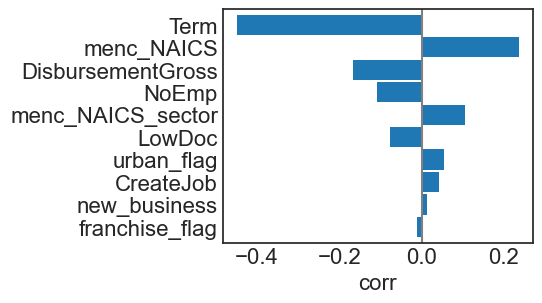

In [24]:
feat_corr(cor_df, 'target', outpath = Path(setup.temp_path))

The target feature is highly correlated with term (in Kaggle notebooks, models have very high performance, and I also see very high performance with this feature).  I think this feature is likely set by the creditworthiness of the businesses, as it is such a strong predictor

After term, NAICS seems to be the most significant feature.  Let's look at the NAICS feature now

##### NAICS correlations

,index,corr,corr_abs
3,menc_NAICS_sector,0.425054,0.425054
7,DisbursementGross,-0.266137,0.266137
0,Term,-0.241501,0.241501
1,target,0.235621,0.235621
4,NoEmp,-0.137371,0.137371
5,CreateJob,0.078139,0.078139
6,LowDoc,-0.074854,0.074854
9,urban_flag,0.054654,0.054654
10,franchise_flag,0.048179,0.048179
8,new_business,0.035651,0.035651


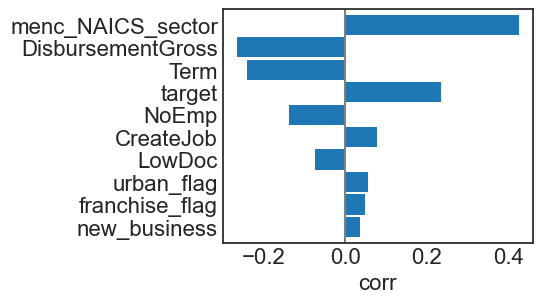

In [25]:
feat_corr(cor_df, 'menc_NAICS', outpath = Path(setup.temp_path))

The strong correlation with menc_NAICS_sector is to be expected. In addition to that, there are strong correlations with RevLineCr, RetainedJob, and other features. 

##### NAICS sector correlations

,index,corr,corr_abs
2,menc_NAICS,0.425054,0.425054
7,DisbursementGross,-0.144841,0.144841
0,Term,-0.123234,0.123234
1,target,0.104485,0.104485
4,NoEmp,-0.071064,0.071064
10,franchise_flag,0.039679,0.039679
6,LowDoc,-0.011184,0.011184
8,new_business,-0.010669,0.010669
9,urban_flag,-0.005813,0.005813
5,CreateJob,0.004385,0.004385


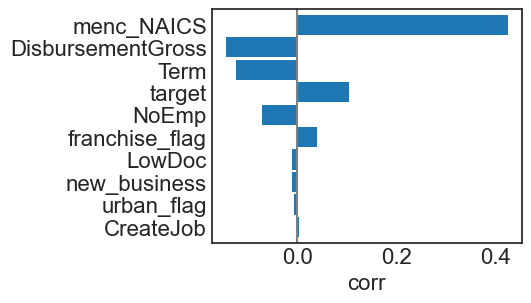

In [26]:
feat_corr(cor_df, 'menc_NAICS_sector', outpath = Path(setup.temp_path))

The overall pattern is similar to the full NAICS, but a bit weaker.

## Term
This feature is highly predictive and its use makes an excellent model.  I will probably drop it as it's probably set in proportion to creditworthiness.  Using this feature would make sense if you want to evaluate how well SBA is assigning risk, or to predict defaults given known risk.  But here I omit it because it makes a model so good NAICS doesn't matter.  Also removing this feature means predicting risk without the (implicit) benefit of the credit-worthiness assigned by the SBA.

I am going to explore how term is related to the target a little

##### Quartile stats

In [27]:
train_df['term_cat'] = pd.qcut(train_df['Term'], q=4)

In [28]:
train_df.groupby('term_cat') \
    .agg({'Term': 'mean', 'LoanNr_ChkDgt':'count',
          'target':'mean'})

,Term,LoanNr_ChkDgt,target
term_cat,,,
"(-0.001, 60.0]",40.401552,134817,0.431689
"(60.0, 84.0]",81.204326,151425,0.115245
"(84.0, 120.0]",110.847782,56452,0.126231
"(120.0, 527.0]",237.203305,82900,0.044041


There is a steady decrease in risk as term increases.  I wonder if enough time has passed to evaluate very long loans

##### Value counts, describe

In [29]:
train_df['Term'].value_counts().head(10)

Term
84     119113
60      40553
120     33544
240     33540
300     17242
36      10271
180      9360
12       8105
48       7569
72       4603
Name: count, dtype: int64

5 or 7 year terms are common!

In [30]:
train_df['Term'].describe()

count    425594.000000
mean        102.597579
std          74.492348
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         527.000000
Name: Term, dtype: float64

## NAICS
What is the variation of term rates within vs. between sectors?

In [31]:
importlib.reload(sg_plot)

<module 'sba_gnn.sba_gnn.sg_plot' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_plot.py'>

In [32]:
# Summarize target rates and counts by NAICS
naics_info = sg_plot.naics_variance_data(sba_loans)
naics_info = naics_info.merge(naics_desc.rename(columns={'NAICS07':'NAICS'}),
                             how='left', on='NAICS')
naics_info.to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates.csv'), index=False)

In [33]:
naics_info.head(5)

,NAICS,target,count,NAICS_sector,count_cat,target_cat,NAICS_sector_desc,target_sd,target_cat_sd,NAICS07_desc
0,445310,0.119330,6746,44-45,125289,0.22761,Retail Trade,0.004206,0.001348,"Beer stores, packaged"
1,447110,0.174977,6618,44-45,125289,0.22761,Retail Trade,0.005142,0.001348,Convenience food with gasoline stations
2,451110,0.183920,5883,44-45,125289,0.22761,Retail Trade,0.005591,0.001348,Athletic equipment and supply stores (includin...
3,453220,0.227118,5878,44-45,125289,0.22761,Retail Trade,0.006216,0.001348,Balloon shops
4,453998,0.313694,5652,44-45,125289,0.22761,Retail Trade,0.007450,0.001348,Art supply stores


In [34]:
# Join in NAICS code descriptions

In [35]:
print(naics_info.shape)
print(naics_info[naics_info['count'] > 100].shape)

(1311, 10)
(713, 10)


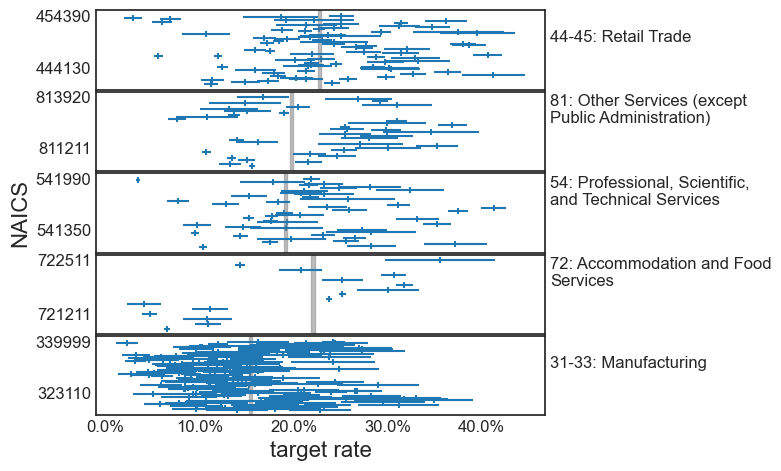

In [36]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count'] > 100], num_sectors=5)
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates.png'),
           bbox_inches='tight')

In [37]:
# Export high-volume data for analysis
naics_info[naics_info['count'] > 100] \
           .sort_values(['target_cat', 'target'], ascending=[False, False]) \
           .to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates_high_vol.csv'), 
                   index=False)